<a href="https://colab.research.google.com/github/elvinmirzazada/ImageSegmentationWithKeras/blob/master/Image_Segmentation_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is Semantic Segmentation?**
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.

This is similar to what us humans do all the time by default. Whenever we are looking at something, then we try to “segment” what portion of the image belongs to which class /label /category.

Essentially, Semantic Segmentation is the technique through which we can achieve this in computers.

You can read more about Segmentation in our post on [Image Segmentation](https://www.learnopencv.com/image-segmentation/).

This post will focus on Semantic Segmentation

So, let’s say we have the following image.

#### Original Image
![Original Image](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

#### Segmented Image

![Segmented Image](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, each pixel in the image is classified to its respective class. For example, the person is one class, the bike is another and the third is the background.

This is, in most simple terms, what Semantic Segmentation is.

#### Let's get started!

## Part 1. Initalization of Libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import libraries
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,Flatten, concatenate,Reshape, Conv2D, MaxPooling2D, Lambda,Activation,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from random import randint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
# %matplotlib inline

## Part 2. The DataSet

I will use image datasets as NumPy array files from drive. 
Drive link: https://drive.google.com/drive/folders/1YSzKI7DiQOKljNOaUwU8dFFhOnQvMR7C?usp=sharing

In [ ]:
DIR = 'drive/My Drive/Colab Notebooks/PersonSegmentation/'

In [ ]:
# Load the dataset
x_train=np.load(DIR + "data/general_data/img_uint8.npy")
y_train=np.load(DIR + "data/general_data/msk_uint8.npy")

# Configure save paths and batch size
PRETRAINED=DIR + 'checkpoints/pretrained_model.h5'
CHECKPOINT=DIR + "checkpoints/bilinear_segmodel-{epoch:02d}-{val_loss:.2f}.h5"
LOGS=DIR + 'logs'
BATCH_SIZE=64
y_train = y_train.reshape(-1, 128, 128, 1)

In [ ]:
len(x_train)

18698

We will only use 3000 images for our project.

In [ ]:
x_train = x_train[:3000]
y_train = y_train[:3000]

In [ ]:
# Verify the mask shape and values
print(np.unique(y_train))
print()
print(x_train.shape, y_train.shape)

[  0 255]

(3000, 128, 128, 3) (3000, 128, 128, 1)


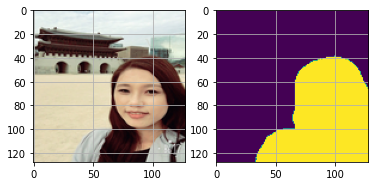

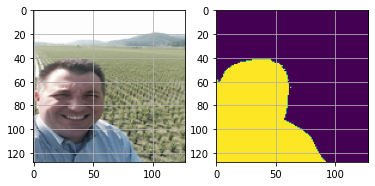

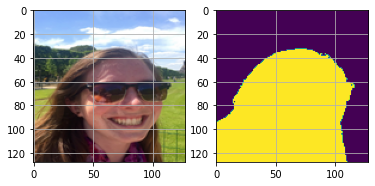

In [ ]:
for i in range(100, 103):
    
    # Get the next image from iterator
    frame = x_train[i]
    mask = y_train[i]
       
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    plt.imshow(frame)
    
    mask = np.reshape(mask, (128, 128))
    fig.add_subplot(1,2,2)
    plt.grid(b=None)
    plt.imshow(mask)
    plt.show()

## Part 3. Create your own data generators

Create functions for Normalize and Denormalize image batches.

In [ ]:
# Total number of images
num_images=x_train.shape[0]

# Preprocessing function (runtime)
def normalize_batch(imgs):
    if imgs.shape[-1] > 1 :
      return (imgs -  np.array([0.50693673, 0.47721124, 0.44640532])) /np.array([0.28926975, 0.27801928, 0.28596011])
    else:
      return imgs.round()
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.28926975, 0.27801928, 0.28596011])) + np.array([0.50693673, 0.47721124, 0.44640532])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

In [ ]:
# Data generator for training and validation

data_gen_args = dict(rescale=1./255,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     validation_split=0.2
                    )

image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize_batch)
mask_datagen = ImageDataGenerator(**data_gen_args,  preprocessing_function=normalize_batch)

In [ ]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_sz=BATCH_SIZE

# Train-val split (80-20)
num_train=int(num_images*0.8)
num_val=int(num_images*0.2) 

train_image_generator = image_datagen.flow(
    x_train,
    batch_size=batch_sz,
    shuffle=True,
    subset='training',
    seed=seed)

train_mask_generator = mask_datagen.flow(
    y_train,
    batch_size=batch_sz,
    shuffle=True,
    subset='training',
    seed=seed)


val_image_generator = image_datagen.flow(
    x_train, 
    batch_size = batch_sz,
    shuffle=True,
    subset='validation',
    seed=seed)

val_mask_generator = mask_datagen.flow(
    y_train,
    batch_size = batch_sz,
    shuffle=True,
    subset='validation',
    seed=seed)

In [ ]:
# combine generators into one which yields image and masks

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

## Part 4. Design our model

In [ ]:
# Convolution block with Transpose Convolution
def deconv_block(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    
    y = Conv2DTranspose(filters=nfilters, kernel_size=size, strides=2, padding = padding, kernel_initializer = kernel_initializer)(tensor)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Activation("relu")(y)
    
    
    return y

# Convolution block with Upsampling+Conv2D
def deconv_block_rez(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2))(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Activation("relu")(y)
    
    
    return y

In [ ]:
# Model architecture
def get_mobile_unet(finetune=False, pretrained=False):

    # Load pretrained model (if any)
    if (pretrained):
        model=load_model(PRETRAINED)
        print("Loaded pretrained model ...\n")
        return model
    
    # Encoder/Feature extractor
    mnv2=tensorflow.keras.applications.mobilenet.MobileNet(input_shape=(128, 128, 3),alpha=0.5, include_top=False, weights='imagenet')
    
    if (finetune):
        print("Freezing initial layer ...\n")
        for layer in mnv2.layers[:-3]:
            layer.trainable = False
    
    x = mnv2.get_layer('conv_pw_11_relu').output

    # Decoder
    x = deconv_block_rez(x, 512)
    x = concatenate([x, mnv2.get_layer('conv_pw_5_relu').output], axis = 3)
    
    x = deconv_block_rez(x, 256)
    x = concatenate([x, mnv2.get_layer('conv_pw_3_relu').output], axis = 3)
                
    x = deconv_block_rez(x, 64)
    x = concatenate([x, mnv2.get_layer('conv_pw_1_relu').output], axis = 3)
    
#     x = deconv_block_rez(x, 32)
#     x = concatenate([x, mnv2.get_layer('input_4').output], axis = 3)
                

    #x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_initializer = 'he_normal')(x)
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(filters=32, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
   
    x = Conv2DTranspose(1, (1,1), padding='same')(x)
    x = Activation('sigmoid', name="op")(x)
    
    
    model = Model(inputs=mnv2.input, outputs=x)
    
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model
  
model=get_mobile_unet()

# Model summary
model.summary()

5578752/5577668 [==============================] - 1s 0us/step
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 130, 130, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 16)   432         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 16)   64         

#### We can use different models

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras as keras


n_classes = 1

In [ ]:
inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
# conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
# conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
# conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
# conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.1) (conv3)
# conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3)
# conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.1) (conv4)
# conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
# conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
# conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
# conv5 = BatchNormalization() (conv5)
pooling5 = MaxPooling2D(pool_size=(2, 2)) (conv5)

conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling5)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.3) (conv6)
# conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv6)
# conv6 = BatchNormalization() (conv6)


upsample7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv5])
conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
# conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv7)
# conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv4])
conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.2) (conv8)
# conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv8)
# conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv3])
conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.2) (conv9)
# conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv9)
# conv9 = BatchNormalization() (conv9)

upsample10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv9)
upsample10 = concatenate([upsample10, conv2])
conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample10)
conv10 = BatchNormalization() (conv10)
conv10 = Dropout(0.2) (conv10)
# conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv10)
# conv10 = BatchNormalization() (conv10)

upsample11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv10)
upsample11 = concatenate([upsample11, conv1], axis=3)
conv11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample11)
conv11 = BatchNormalization() (conv11)
conv11 = Dropout(0.3) (conv11)
# conv11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv11)
# conv11 = BatchNormalization() (conv11)

outputs = Conv2D(n_classes, (1, 1), activation='sigmoid') (conv11)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           batch_normalization[0][0]        
____________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001),metrics=['accuracy'])

## Part 5. Train Model

In [ ]:
# Plot model architecture
# plot_model(model, to_file='portrait_seg.png')

# Save checkpoints
checkpoint = ModelCheckpoint(CHECKPOINT, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')

# Callbacks 
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=15, min_lr=0.000001, verbose=1)
tensorboard = TensorBoard(log_dir=LOGS, histogram_freq=0,
                          write_graph=True, write_images=True)

callbacks_list = [checkpoint, tensorboard,reduce_lr]



# Train the model
model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=num_train/batch_sz,
    validation_data=val_generator, 
    validation_steps=num_val/batch_sz,
    use_multiprocessing=True,
    workers=2,
    callbacks=callbacks_list)

#Sample run: python train.py
saved_model = DIR + 'saved_model/my_model.pb'
!mkdir -p saved_model
model.save(saved_model) 

Epoch 1/20
37/37 [============================>.] - ETA: 30s - loss: 0.2275 - acc: 0.8962 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.

Epoch 00001: val_loss improved from inf to 1.06146, saving model to drive/My Drive/Colab Notebooks/PersonSegmentation/checkpoints/bilinear_segmodel-01-1.06.h5
38/37 [==============================] - 2496s 66s/step - loss: 0.2258 - acc: 0.8970 - val_loss: 1.0615 - val_acc: 0.8409
Epoch 2/20
37/37 [============================>.] - ETA: 29s - loss: 0.1292 - acc: 0.9399 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.

Epoch 00002: val_loss improved from 1.06146 to 0.33095, saving model to drive/My Drive/Colab Notebooks/PersonSegmentation/checkpoints/bilinear_segmodel-02-0.33.h5
38/37 [=============================

## Part 6. Save Model

In [ ]:
saved_model = DIR + 'saved_model/my_model.pb'
!mkdir -p saved_model
model.save(saved_model) 

## Part 7. Test our Model

In [ ]:
newmodel = get_mobile_unet()

newmodel.load_weights(DIR + 'checkpoints/bilinear_segmodel-18-0.09.h5')

In [ ]:
# Load a test dataset 
x_test=np.load(DIR + "data/general_data/test_xtrain.npy")
y_test=np.load(DIR + "data/general_data/test_ytrain.npy")
y_test = y_test.reshape(-1, 128, 128, 1)

In [ ]:
x_test = x_test[10:20]
y_test = y_test[10:20]

In [ ]:
model_path = DIR + 'checkpoints/bilinear_segmodel-18-0.09.h5'

print(os.listdir(DIR + 'checkpoints'))

# Load a trained model checkpoint
# new_model = tensorflow.keras.models.load_model(DIR + 'saved_model/my_model.pb')
# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    


# Evaluate model 
score = newmodel.evaluate(np.float32(x_test/255.0), np.float32(y_test/255.0), verbose=0)

# Print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Sample run: python eval.py checkpoints/up_super_model-102-0.06.hdf5


['bilinear_segmodel-04-4.15.hdf5', 'bilinear_segmodel-05-2.96.hdf5', 'bilinear_segmodel-01-5.92.h5', 'bilinear_segmodel-02-4.16.h5', 'bilinear_segmodel-03-2.32.h5', 'bilinear_segmodel-04-1.04.h5', 'bilinear_segmodel-05-0.64.h5', 'bilinear_segmodel-06-0.43.h5', 'bilinear_segmodel-07-0.30.h5', 'bilinear_segmodel-08-0.22.h5', 'bilinear_segmodel-09-0.18.h5', 'bilinear_segmodel-10-0.16.h5', 'bilinear_segmodel-11-0.14.h5', 'bilinear_segmodel-12-0.11.h5', 'bilinear_segmodel-13-0.10.h5', 'bilinear_segmodel-16-0.10.h5', 'bilinear_segmodel-18-0.09.h5', 'bilinear_segmodel-01-3.27.h5', 'bilinear_segmodel-02-1.33.h5', 'bilinear_segmodel-03-0.72.h5', 'bilinear_segmodel-04-0.33.h5', 'bilinear_segmodel-05-0.25.h5', 'bilinear_segmodel-06-0.21.h5', 'bilinear_segmodel-08-0.18.h5', 'bilinear_segmodel-09-0.17.h5', 'bilinear_segmodel-10-0.14.h5']
Test loss: 0.19244949519634247
Test accuracy: 0.921600341796875


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
def predict(x_test, mdl):
  for x in x_test:
    img=np.float32(np.array(x)/255.0)
    # img=img[:,:,0:3]

    # Reshape input and threshold output
    out=mdl.predict(img.reshape(1,128,128,3))
    out=np.float32((out>0.5)).reshape(128,128,1)

    # Input image
    plt.figure("Input")
    plt.imshow(img)


    # Output image
    plt.figure("Output")
    plt.imshow(out*img)

    plt.show()

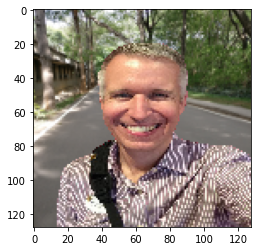

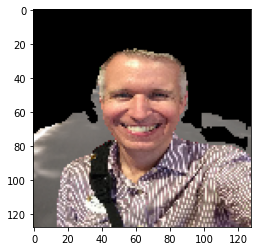

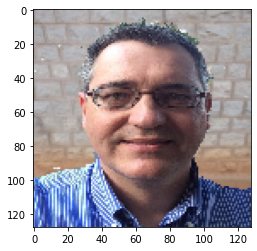

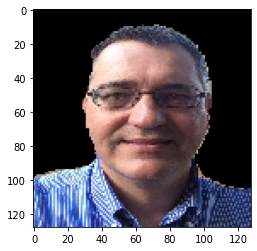

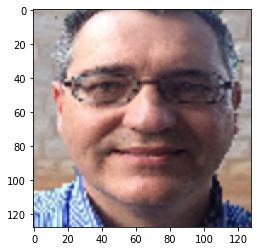

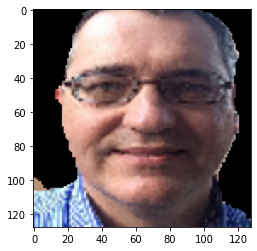

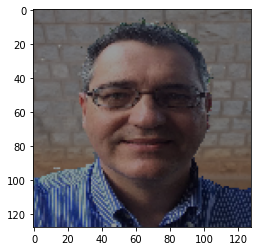

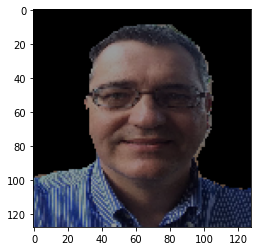

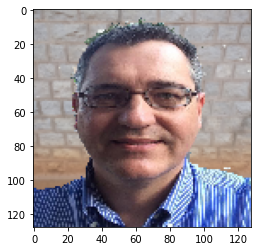

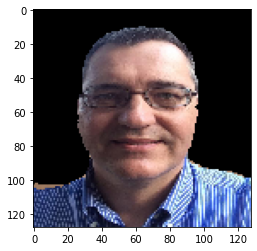

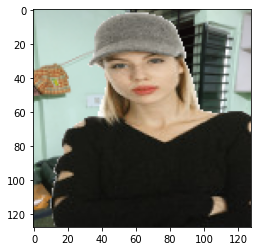

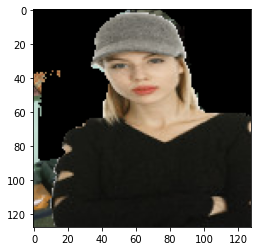

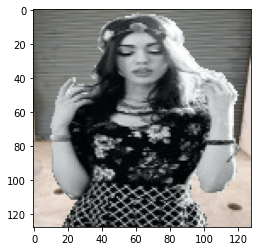

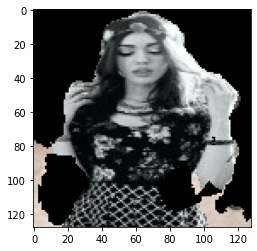

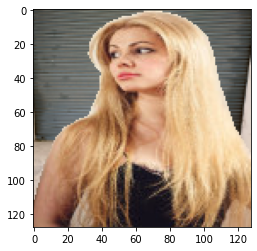

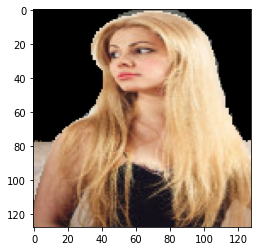

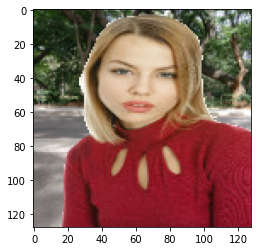

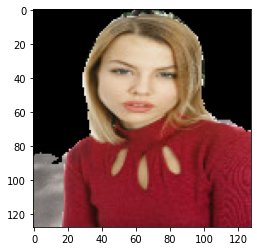

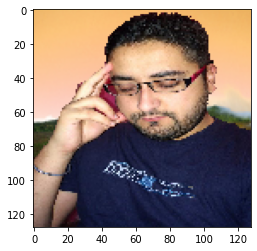

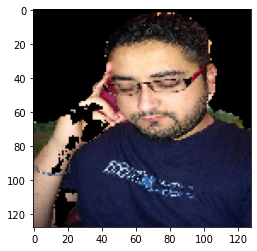

In [ ]:
predict(x_test=x_test, mdl=newmodel)

## Part 8. Change Keras Model to Tensorflow Model(Traditional)

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import graph_io



# Clear any previous session.
tf.keras.backend.clear_session()

save_pb_dir = DIR + 'saved_model'
model_fname = './model/model.h5'
def freeze_graph(graph, session, output, save_pb_dir=save_pb_dir, save_pb_name='frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen

# This line must be executed before loading Keras model.
tf.keras.backend.set_learning_phase(0) 
newmodel = get_mobile_unet()

newmodel.load_weights(DIR + 'saved_model/model_new.pb')
# model = load_model(model_fname)

session = tf.keras.backend.get_session()

INPUT_NODE = [t.op.name for t in newmodel.inputs]
OUTPUT_NODE = [t.op.name for t in newmodel.outputs]
print(INPUT_NODE, OUTPUT_NODE)
frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in newmodel.outputs], save_pb_dir=save_pb_dir)

['input_1'] ['op/Sigmoid']
INFO:tensorflow:Froze 141 variables.
INFO:tensorflow:Converted 141 variables to const ops.


In [ ]:
from tensorflow.python.platform import gfile

with tf.Session() as sess:
  with gfile.FastGFile(DIR+'saved_model/frozen_model.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    g_in = tf.import_graph_def(graph_def=graph_def)

In [ ]:
writer = tf.summary.FileWriter('./log')
writer.add_graph(sess.graph)
writer.flush()
writer.close()